In [ ]:
!pip install tensorflow
!pip install datasets
!pip install transformers
!pip install torch

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer

In [ ]:
#carregando dataset do hf_hub
emotions = load_dataset("emotion")
train_ds = emotions["train"]

#visualizando infos sobre o dataset
print(train_ds)
print(train_ds.features)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [ ]:

#transformando o dataset em um dataframe
emotions.set_format(type="pandas")
df = emotions["train"][:]
print(df.head())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


                                                text  label label_name
0                            i didnt feel humiliated      0    sadness
1  i can go from feeling so hopeless to so damned...      0    sadness
2   im grabbing a minute to post i feel greedy wrong      3      anger
3  i am ever feeling nostalgic about the fireplac...      2       love
4                               i am feeling grouchy      3      anger


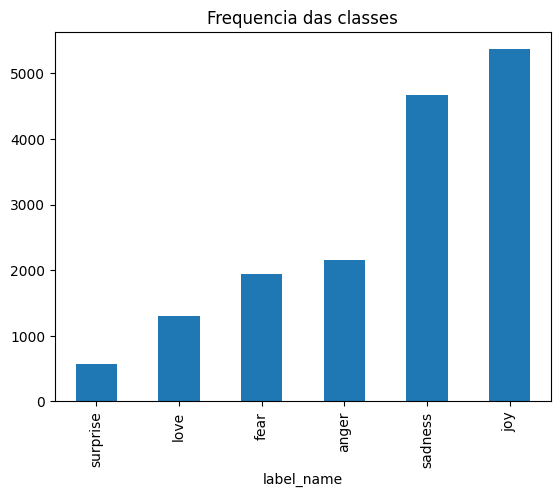

In [ ]:
#criando uma nova coluna com a label correspondente
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
print(df.head())

#vendo a distribuicao de emocoes no df
df["label_name"].value_counts(ascending=True).plot.bar()
plt.title("Frequencia das classes")
plt.show()






In [ ]:
emotions.reset_format()

In [ ]:
#carregar o tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

#funcao que aplica a tokenizacao ao dataset
def tokenize_ds(batch):
  #completa com zeros e quebra com base no tamanho
  return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize_ds(emotions["train"][:2]))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
#aplicando a funcao de tokenizacao no ds de emocoes
emotions_tok = emotions.map(tokenize_ds, batched=True, batch_size=None)

print(emotions_tok["train"].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


#aplicando feature extractors

In [ ]:
from transformers import AutoModel

model_cktp = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_cktp).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def ext_hidden_states(batch):
  #passar os inputs do modelo para gpu ou cpu
  inputs = { k:v.to(device)for k,v in batch.items() if k in tokenizer.model_input_names}

  #extrair o ultimo hidden state
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
#convertendo os input_ids e attention_mask para o formato torch
emotions_tok.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
#extraindo os hidden states
#small_sample = emotions_tok["train"].select(range(100))  # Pega os primeiros 100 exemplos
#emotions_hidden = small_sample.map(ext_hidden_states, batched=True)

#para aplicar em todo o dataset:
emotions_hiddden = emotions_tok.map(ext_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_hidden.column_names

NameError: name 'emotions_hidden' is not defined

In [ ]:
import numpy as np

#criando uma matriz feature
X_train = np.array(emotions_hiddden["train"]["hidden_state"])
X_valid = np.array(emotions_hiddden["validation"]["hidden_state"])
y_train = np.array(emotions_hiddden["train"]["label"])
y_valid = np.array(emotions_hiddden["validation"]["label"])

X_train.shape, X_valid.shape

In [ ]:
#visualizando o set de treinamento
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
#criando um df de embeddings 2d
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
    gridsize=20, linewidths=(0,))


  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
#treinando um classificador simples

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

In [ ]:
#plotando matriz de confusao

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Matriz de Consusao Normalizada")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

#Modelos Fine-Tuning


In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_cktp, num_labels=num_labels)
         .to(device))

In [ ]:
#metricas de perfomance
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return { "accuracy": acc, "f1": f1}

In [ ]:
#treinamento do modelo
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_tok["train"]) // batch_size
model_name = f"{model_cktp}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics = compute_metrics,
                  train_dataset = emotions_tok["train"],
                  eval_dataset = emotions_tok["validation"],
                  tokenizer = tokenizer)

trainer.train()

In [ ]:
preds_output = trainer.predict(emotions_tok["validation"])